In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [6]:
# Load data
data = pd.read_csv('Month_Value_1.csv', engine='python', skipfooter=3)

In [10]:
# pre-processing
data['Period']=pd.to_datetime(data['Period'], format='mm.dd.yyyy')
data.set_index(['Period'], inplace=True)

# Plot data
data.plot()
plt.title('Monthly Car Sales')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

ValueError: time data '01.01.2015' does not match format 'mm.dd.yyyy' (match)

In [4]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Grid Search / Hyperparameter Optimization for Model selection - (be able to pick up the smallest AIC Value).
# Generate all different combinations of seasonal p, q and q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# SARIMAX returns the AIC Value
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [5]:
# Train the data and predict the last year
training_data = data['1960-01-01':'1967-12-01']
test_data = data['1968-01-01':'1968-12-01']

In [6]:
data

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587
...,...
1968-05-01,26099
1968-06-01,21084
1968-07-01,18024


In [7]:
# Ignore warning messages
warnings.filterwarnings("ignore")

# Generate an AIC Value
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(training_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue
results

In [14]:
mod = sm.tsa.statespace.SARIMAX(training_data,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
AIC.append(results.aic)
SARIMAX_model.append([param, param_seasonal])

In [15]:
# AIC Value?
mod

In [16]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 779.6155943611168 for model SARIMAX(3, 1, 1)x(3, 1, 1, 12)


In [17]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(training_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [18]:
# Use plot diagnostics to check if it meets our expecatations
results.plot_diagnostics(figsize=(20, 14))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1440x1008 with 0 Axes>

In [19]:
# Results (TRIAL): 3 types of forecasting

In [20]:
# Sample prediction with 1-step ahead forecasting of the last year 1967 
# Model is asked to predict data using existing data 

pred0 = results.get_prediction(start='1966-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [21]:
# Sample prediction with dynamic forecasting of the last year 1967
# Model is asked to predict data using existing data 

pred1 = results.get_prediction(start='1966-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [22]:
# True forecasting 
# Model is asked to predict data its not seen before 

pred2 = results.get_forecast('1970-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1968-01-01':'1968-12-01'])

1968-01-01    10974.985043
1968-02-01    11555.094186
1968-03-01    18935.340406
1968-04-01    20315.665813
1968-05-01    22184.839708
1968-06-01    21577.992502
1968-07-01    13467.889196
1968-08-01    14017.650191
1968-09-01    12886.171677
1968-10-01    16859.712094
1968-11-01    18411.201657
1968-12-01    14988.634293
Freq: MS, Name: predicted_mean, dtype: float64


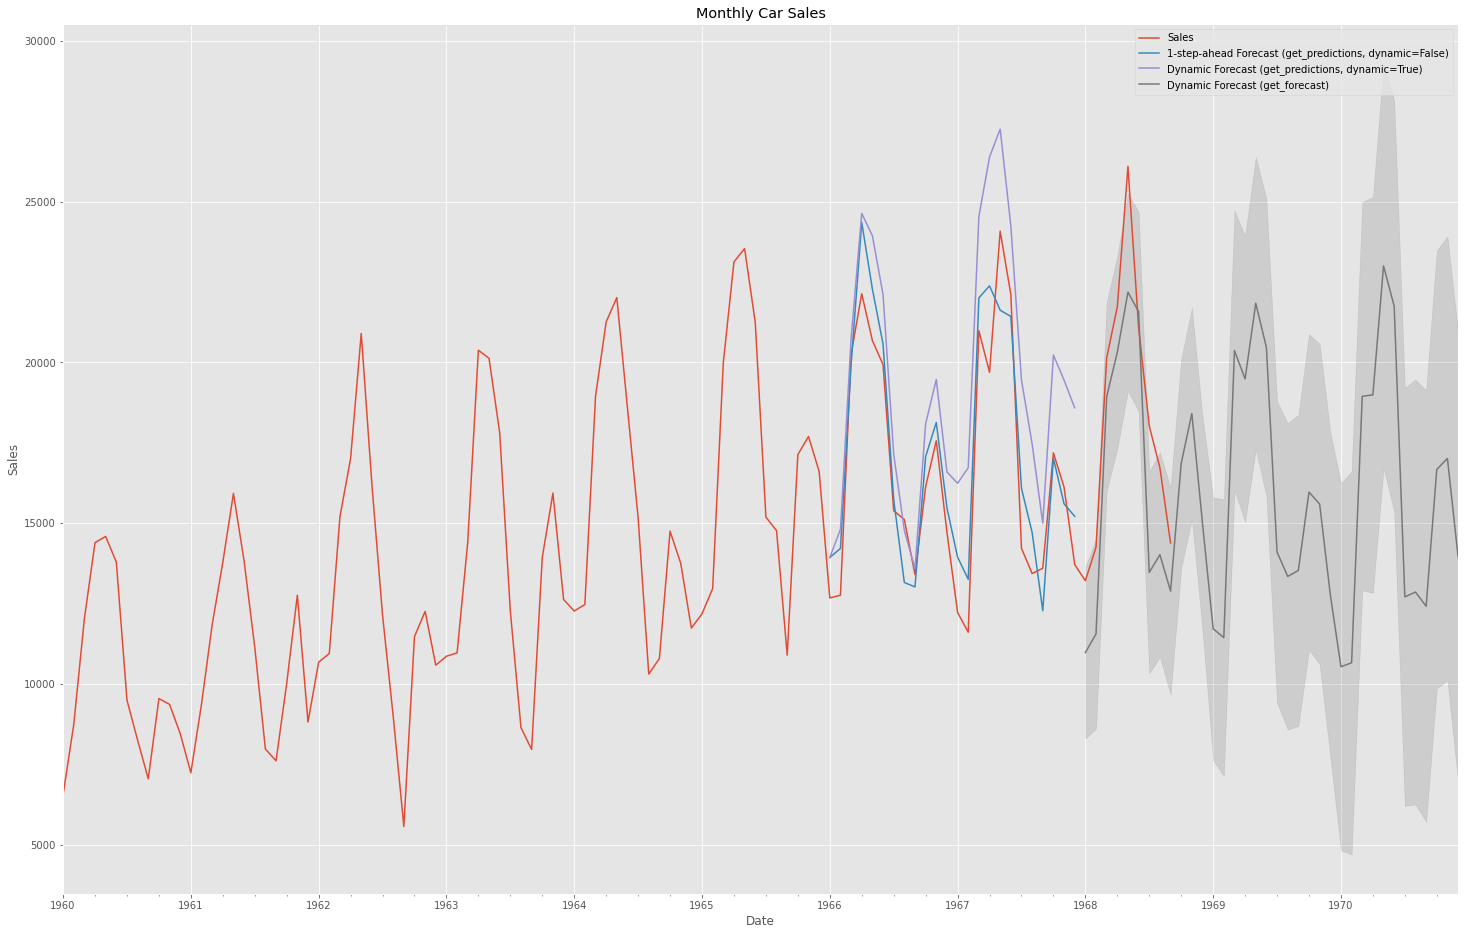

In [23]:
# Plot all data

ax = data.plot(figsize=(25, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.title('Monthly Car Sales')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend()
plt.show()